#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/desafio-de-prediccion-de-precios-de-portatiles

## Librerias

In [25]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import Toolbox_ML as tb
import lightgbm as lgb

from collections import Counter
from lightgbm import LGBMClassifier, LGBMRegressor
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.metrics import mutual_info_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import median_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import re

## Data

In [26]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./data/train.csv")

## Data exploration

In [27]:
df.Product.unique()

array(['Inspiron 5567', 'X541NA (N4200/4GB/1TB/W10)', 'Portege Z30-C-1CW',
       'Alienware 17', 'Latitude E7270', 'ZenBook Flip',
       'X541UA-DM1897 (i3-6006U/4GB/256GB/FHD/Linux)', 'GP62M 7RDX',
       'UX430UQ-GV209R (i7-7500U/8GB/256GB/GeForce', 'Rog GL553VE-FY052T',
       'X540SA-RBPDN09 (N3710/4GB/1TB/W10)', 'Inspiron 5570',
       'Tecra A50-C-1ZV', '15-cd005nv (A9-9420/6GB/256GB/Radeon',
       'Satellite Pro', 'Latitude 5590', 'Yoga 520-14IKB',
       'Aspire E5-575', 'Thinkpad P51', 'Aspire A517-51G', 'Yoga Book',
       '17-ak002nv (A10-9620P/6GB/2TB/Radeon', 'EliteBook 820',
       'Omen 17-W295', 'Precision M5520',
       'X540UA-DM186 (i3-6006U/4GB/1TB/FHD/Linux)', 'Extensa EX2540-58KR',
       'IdeaPad 310-15IKB', 'IdeaPad 320-15IAP', 'ProBook 640',
       'Inspiron 3576', 'GL553VE-FY082T (i7-7700HQ/8GB/1TB',
       'B51-80 (i7-6500U/8GB/1008GB/Radeon', 'Vostro 3568',
       'Chromebook CB5-571-C1DZ', 'IdeaPad 320-15ABR', 'Inspiron 3552',
       'X553SA-XX021T (N305

In [28]:
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df[['Modelo', 'Submodelo']] = df['Product'].str.extract(r'(\w+)\s*(.*)')
df['Submodelo'] = df['Submodelo'].str.replace('-', ' ').str.split('(').str[0].str.strip()

In [3]:
df.head()

id  laptop_ID  Company                     Product   TypeName  Inches  \
0  268       1002     Dell               Inspiron 5567   Notebook    15.6   
1  347        867     Asus  X541NA (N4200/4GB/1TB/W10)   Notebook    15.6   
2  353        966  Toshiba           Portege Z30-C-1CW   Notebook    13.3   
3  578        767     Dell                Alienware 17     Gaming    15.6   
4   42       1241     Dell              Latitude E7270  Ultrabook    12.5   

                  ScreenResolution                                   Cpu  \
0                         1366x768            Intel Core i7 7500U 2.7GHz   
1                         1366x768  Intel Pentium Quad Core N4200 1.1GHz   
2                Full HD 1920x1080            Intel Core i5 6200U 2.3GHz   
3  IPS Panel 4K Ultra HD 3840x2160           Intel Core i7 7700HQ 2.8GHz   
4  Full HD / Touchscreen 1920x1080            Intel Core i5 6300U 2.4GHz   

    Ram                Memory                      Gpu       OpSys  Weight  \
0   8GB               1TB HDD       AMD Radeon R7 M445  Windows 10  2.36kg   
1   4GB               1TB HDD    Intel HD Graphics 505  Windows 10     2kg   
2   8GB             256GB SSD    Intel HD Graphics 520   Windows 7   1.2kg   
3  16GB  256GB SSD +  1TB HDD  Nvidia GeForce GTX 1070  Windows 10  4.42kg   
4   8GB             256GB SSD    Intel HD Graphics 520   Windows 7  1.26kg   

   Price_euros  
0       749.00  
1       449.00  
2      1460.00  
3      2868.99  
4      1713.37

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


In [5]:
df.describe()

id    laptop_ID      Inches  Price_euros
count   912.000000   912.000000  912.000000   912.000000
mean    645.091009   666.192982   15.011404  1108.122873
std     380.313813   384.873846    1.411744   714.597741
min       0.000000     1.000000   10.100000   174.000000
25%     319.750000   330.500000   14.000000   589.000000
50%     636.500000   673.500000   15.600000   949.000000
75%     980.250000   998.500000   15.600000  1458.500000
max    1302.000000  1320.000000   18.400000  6099.000000

In [6]:
tb.describe_df(df)

id laptop_ID Company Product TypeName   Inches  \
Tipos           int64     int64  object  object   object  float64   
% Faltante        0.0       0.0     0.0     0.0      0.0      0.0   
Valores Únicos    912       912      19     475        6       15   
% Cardinalidad  100.0     100.0    2.08   52.08     0.66     1.64   

               ScreenResolution     Cpu     Ram  Memory     Gpu   OpSys  \
Tipos                    object  object  object  object  object  object   
% Faltante                  0.0     0.0     0.0     0.0     0.0     0.0   
Valores Únicos               35     104       8      36      91       9   
% Cardinalidad             3.84    11.4    0.88    3.95    9.98    0.99   

                Weight Price_euros  
Tipos           object     float64  
% Faltante         0.0         0.0  
Valores Únicos     158         614  
% Cardinalidad   17.32       67.32

In [7]:
tb.tipifica_variables(df, 8, 15)

nombre_variable      tipo_sugerido
0                 id  Numérica Continua
1          laptop_ID  Numérica Continua
2            Company  Numérica Discreta
3            Product  Numérica Continua
4           TypeName         Categórica
5             Inches  Numérica Discreta
6   ScreenResolution  Numérica Discreta
7                Cpu  Numérica Discreta
8                Ram  Numérica Discreta
9             Memory  Numérica Discreta
10               Gpu  Numérica Discreta
11             OpSys  Numérica Discreta
12            Weight  Numérica Continua
13       Price_euros  Numérica Continua

In [4]:
df.Company.value_counts()

Company
Lenovo       208
Dell         207
HP           189
Asus         108
Acer          75
Toshiba       37
MSI           34
Apple         17
Mediacom       7
Razer          6
Samsung        6
Fujitsu        3
Microsoft      3
Vero           3
Xiaomi         3
Google         2
Chuwi          2
LG             1
Huawei         1
Name: count, dtype: int64

In [9]:
df.Memory.unique()

array(['1TB HDD', '256GB SSD', '256GB SSD +  1TB HDD',
       '512GB SSD +  2TB HDD', '128GB SSD +  1TB HDD', '128GB SSD',
       '1TB SSD', '64GB Flash Storage', '2TB HDD', '500GB HDD',
       '1.0TB Hybrid', '16GB Flash Storage', '256GB Flash Storage',
       '180GB SSD', '32GB Flash Storage', '512GB SSD',
       '512GB SSD +  1TB HDD', '256GB SSD +  500GB HDD',
       '256GB SSD +  2TB HDD', '1TB SSD +  1TB HDD', '64GB SSD',
       '128GB Flash Storage', '256GB SSD +  1.0TB Hybrid', '32GB SSD',
       '512GB Flash Storage', '240GB SSD', '256GB SSD +  256GB SSD',
       '16GB SSD', '8GB SSD', '64GB Flash Storage +  1TB HDD',
       '1.0TB HDD', '1TB HDD +  1TB HDD', '512GB SSD +  512GB SSD',
       '128GB SSD +  2TB HDD', '32GB HDD', '512GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [10]:
def convert_capacity(capacity_str):
    if 'TB' in capacity_str:
        return float(capacity_str.replace('TB', '').strip()) * 1000
    elif 'GB' in capacity_str:
        return float(capacity_str.replace('GB', '').strip())
    else:
        return 0

# Función para descomponer cada entrada en los componentes especificados
def decompose_info(row):
    # Buscar la capacidad de almacenamiento
    capacities = re.findall(r'\d+(?:\.\d+)?[TG]B', row)
    total_capacity = sum(convert_capacity(c) for c in capacities)
    
    # Buscar el tipo de almacenamiento
    if 'SSD' in row and 'HDD' in row:
        storage_type = 'SSD/HDD'
    elif 'SSD' in row and 'Hybrid' in row:
        storage_type = 'SSD/Hybrid'
    elif 'HDD' in row and 'Flash Storage' in row:
        storage_type = 'HDD/Flash Storage'
    elif 'SSD' in row:
        storage_type = 'SSD'
    elif 'HDD' in row:
        storage_type = 'HDD'
    elif 'Flash Storage' in row:
        storage_type = 'Flash Storage'
    elif 'Hybrid' in row:
        storage_type = 'Hybrid'
    
    # Buscar la combinación de almacenamiento
    if '+' in row:
        multiple_storage = True
    else:
        multiple_storage = False
    
    return pd.Series([total_capacity, storage_type, multiple_storage])


In [11]:
# Aplicar la función al DataFrame
df[['Capacity', 'Storage Type', 'Multiple Storage']] = df['Memory'].apply(decompose_info)

In [12]:
df.Capacity.unique()

array([1000.,  256., 1256., 2512., 1128.,  128.,   64., 2000.,  500.,
         16.,  180.,   32.,  512., 1512.,  756., 2256.,  240.,    8.,
       1064., 1024., 2128.])

In [13]:
df.Ram.value_counts()

Ram
8GB     434
4GB     274
16GB    125
6GB      32
2GB      16
12GB     15
32GB     14
24GB      2
Name: count, dtype: int64

In [14]:
df.Cpu.unique()

array(['Intel Core i7 7500U 2.7GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Core i5 6200U 2.3GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i5 6300U 2.4GHz', 'Intel Core i3 6006U 2GHz',
       'Intel Pentium Quad Core N3710 1.6GHz',
       'Intel Core i7 8550U 1.8GHz', 'AMD A9-Series A9-9420 3GHz',
       'Intel Pentium Dual Core 4405U 2.1GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i3 7100U 2.4GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Xeon E3-1535M v6 3.1GHz',
       'Intel Atom x5-Z8550 1.44GHz', 'AMD A10-Series 9620P 2.5GHz',
       'Intel Core i5 7300U 2.6GHz',
       'Intel Celeron Dual Core N3350 1.1GHz',
       'Intel Core i7 6500U 2.5GHz', 'Intel Core i3 6006U 2.0GHz',
       'Intel Celeron Dual Core 3205U 1.5GHz',
       'AMD A12-Series 9720P 3.6GHz',
       'Intel Celeron Dual Core N3050 1.6GHz',
       'Intel Core i3 7130U 2.7GHz', 'Intel Core i5 7300HQ 2.5GHz',
       'Intel Core i5 7200U 2.7GHz', 'Intel Core i7 7820HQ 2.9GHz

In [15]:
df.Cpu

0                Intel Core i7 7500U 2.7GHz
1      Intel Pentium Quad Core N4200 1.1GHz
2                Intel Core i5 6200U 2.3GHz
3               Intel Core i7 7700HQ 2.8GHz
4                Intel Core i5 6300U 2.4GHz
                       ...                 
907    Intel Celeron Dual Core N3060 1.6GHz
908              Intel Core i5 6200U 2.3GHz
909               AMD A8-Series 7410 2.2GHz
910              Intel Core i7 7600U 2.8GHz
911              Intel Core i7 7500U 2.7GHz
Name: Cpu, Length: 912, dtype: object

In [16]:
def check_ghz(value):
    return bool(re.search(r'\d+(\.\d+)?GHz', value))

# Comprobar si "GHz" está presente en todos los valores de la columna 'CPU'
all_ghz = df['Cpu'].apply(check_ghz).all()

print("Todos los valores contienen 'GHz':", all_ghz)

Todos los valores contienen 'GHz': True


In [17]:
df.columns

Index(['id', 'laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_euros', 'Capacity', 'Storage Type', 'Multiple Storage'],
      dtype='object')

In [18]:
# Función para extraer información y dividir en columnas
def split_info(row):
    # Extraer marca (Intel o AMD)
    if 'Intel' in row:
        brand = 'Intel'
    elif 'AMD' in row:
        brand = 'AMD'
    else:
        brand = None
    
    # Extraer frecuencia (con Ghz)
    ghz = re.search(r'\d+(\.\d+)?GHz', row)
    ghz = ghz.group() if ghz else None
    
    # Extraer el resto
    rest = row
    if brand:
        rest = rest.replace(brand, '').strip()
    if ghz:
        rest = rest.replace(ghz, '').strip()
    
    return pd.Series([brand, ghz, rest])

# Aplicar la función al DataFrame
df[['Marca CPU', 'GHz CPU', 'Modelo CPU']] = df['Cpu'].apply(split_info)



In [19]:
df["GHz CPU"].unique()

array(['2.7GHz', '1.1GHz', '2.3GHz', '2.8GHz', '2.4GHz', '2GHz', '1.6GHz',
       '1.8GHz', '3GHz', '2.1GHz', '2.5GHz', '3.1GHz', '1.44GHz',
       '2.6GHz', '2.0GHz', '1.5GHz', '3.6GHz', '2.9GHz', '2.2GHz',
       '1.2GHz', '2.50GHz', '1.0GHz', '1.3GHz', '2.70GHz', '3.2GHz',
       '0.9GHz', '1.9GHz', '1.60GHz', '1.92GHz'], dtype=object)

In [20]:
def split_info_2(row):
    # Extraer marca (Intel Nvidia o AMD)
    if 'Intel' in row:
        brand = 'Intel'
    elif 'AMD' in row:
        brand = 'AMD'
    elif 'Nvidia' in row:
        brand = 'Nvidia'
    else:
        brand = None
    
    # Extraer el resto
    rest = row
    if brand:
        rest = rest.replace(brand, '').strip()
    
    return pd.Series([brand, rest])

# Aplicar la función al DataFrame
df[['Marca GPU', 'Modelo GPU']] = df['Gpu'].apply(split_info_2)

In [21]:
df['Marca GPU'].value_counts()

Marca GPU
Intel     522
Nvidia    268
AMD       122
Name: count, dtype: int64

In [22]:
df['Modelo GPU'].value_counts()

Modelo GPU
HD Graphics 620      200
HD Graphics 520      138
UHD Graphics 620      45
GeForce GTX 1050      43
GeForce GTX 1060      31
                    ... 
Radeon R4              1
Radeon R9 M385         1
Iris Pro Graphics      1
Quadro M2200M          1
Quadro M520M           1
Name: count, Length: 88, dtype: int64

In [23]:
df.TypeName.value_counts()

TypeName
Notebook              522
Gaming                138
Ultrabook             135
2 in 1 Convertible     85
Workstation            18
Netbook                14
Name: count, dtype: int64

In [24]:
df.ScreenResolution.unique()

array(['1366x768', 'Full HD 1920x1080', 'IPS Panel 4K Ultra HD 3840x2160',
       'Full HD / Touchscreen 1920x1080', 'IPS Panel Full HD 1920x1080',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'IPS Panel Touchscreen 1920x1200',
       '4K Ultra HD / Touchscreen 3840x2160', 'Touchscreen 1366x768',
       'IPS Panel Retina Display 2880x1800', 'IPS Panel 1366x768',
       'IPS Panel Quad HD+ / Touchscreen 3200x1800',
       'Quad HD+ / Touchscreen 3200x1800', '4K Ultra HD 3840x2160',
       'IPS Panel 2560x1440', '1600x900', 'Touchscreen 2560x1440',
       'IPS Panel Quad HD+ 2560x1440',
       'IPS Panel Retina Display 2304x1440', '1440x900',
       'IPS Panel Retina Display 2560x1600', 'Touchscreen 2256x1504',
       '2560x1440', 'IPS Panel Touchscreen / 4K Ultra HD 3840x2160',
       'IPS Panel Touchscreen 2560x1440', '1920x1080',
       'Touchscreen 2400x1600', 'IPS Panel Full HD 2160x1440',
       'Quad HD+ 3200x1800',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x21

In [25]:
# Función para descomponer cada entrada en los componentes especificados
def decompose_info_2(row):
    # Buscar resolución en el formato "????x????"
    resolution = re.search(r'\b\d{3,4}x\d{3,4}\b', row)
    resolution = resolution.group() if resolution else None

    # Determinar el tipo de panel
    panel_type = 'IPS Panel' in row
    
    # Determinar la calidad de imagen
    if '4K Ultra HD' in row:
        quality = '4K Ultra HD'
    elif 'Quad HD+' in row:
        quality = 'Quad HD+'
    elif 'Full HD' in row:
        quality = 'Full HD'
    elif 'HD' in row:
        quality = 'HD'
    else:
        quality = None
    
    # Determinar si es Touchscreen
    is_touchscreen = 'Touchscreen' in row
    
    return pd.Series([resolution, panel_type, quality, is_touchscreen])



In [26]:
# Aplicar la función al DataFrame
df[['Resolution', 'Panel Type', 'Quality', 'Touchscreen']] = df['ScreenResolution'].apply(decompose_info_2)

- Lo he separado en resolución, en Panel Type (si es IPS panel o no, el retina display únicamente dice si es de Apple o no pero es lo mismo), en la calidad, y en si es táctil

In [27]:
df.Inches.value_counts()

Inches
15.6    474
14.0    143
13.3    111
17.3    108
12.5     28
11.6     21
12.0      6
10.1      4
13.9      4
15.4      3
15.0      3
13.5      3
12.3      2
13.0      1
18.4      1
Name: count, dtype: int64

In [28]:
df.Product.unique()

array(['Inspiron 5567', 'X541NA (N4200/4GB/1TB/W10)', 'Portege Z30-C-1CW',
       'Alienware 17', 'Latitude E7270', 'ZenBook Flip',
       'X541UA-DM1897 (i3-6006U/4GB/256GB/FHD/Linux)', 'GP62M 7RDX',
       'UX430UQ-GV209R (i7-7500U/8GB/256GB/GeForce', 'Rog GL553VE-FY052T',
       'X540SA-RBPDN09 (N3710/4GB/1TB/W10)', 'Inspiron 5570',
       'Tecra A50-C-1ZV', '15-cd005nv (A9-9420/6GB/256GB/Radeon',
       'Satellite Pro', 'Latitude 5590', 'Yoga 520-14IKB',
       'Aspire E5-575', 'Thinkpad P51', 'Aspire A517-51G', 'Yoga Book',
       '17-ak002nv (A10-9620P/6GB/2TB/Radeon', 'EliteBook 820',
       'Omen 17-W295', 'Precision M5520',
       'X540UA-DM186 (i3-6006U/4GB/1TB/FHD/Linux)', 'Extensa EX2540-58KR',
       'IdeaPad 310-15IKB', 'IdeaPad 320-15IAP', 'ProBook 640',
       'Inspiron 3576', 'GL553VE-FY082T (i7-7700HQ/8GB/1TB',
       'B51-80 (i7-6500U/8GB/1008GB/Radeon', 'Vostro 3568',
       'Chromebook CB5-571-C1DZ', 'IdeaPad 320-15ABR', 'Inspiron 3552',
       'X553SA-XX021T (N305

In [29]:
df.OpSys.unique()

array(['Windows 10', 'Windows 7', 'Linux', 'Chrome OS', 'No OS',
       'Mac OS X', 'Windows 10 S', 'macOS', 'Android'], dtype=object)

In [30]:
df.columns

Index(['id', 'laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_euros', 'Capacity', 'Storage Type', 'Multiple Storage',
       'Marca CPU', 'GHz CPU', 'Modelo CPU', 'Marca GPU', 'Modelo GPU',
       'Resolution', 'Panel Type', 'Quality', 'Touchscreen'],
      dtype='object')

In [3]:
df.Weight = df.Weight.str.replace('kg','',regex=False)
df.Weight = df.Weight.astype(float)

df.Ram = df.Ram.str.replace('GB','',regex=False)
df.Ram = df.Ram.astype(float)


In [ ]:
df['GHz CPU'] = df['GHz CPU'].str.replace('GHz','',regex=False)
df['GHz CPU'] = df['GHz CPU'].astype(float)

## Data processing

-----------------------------------------------------------------------------------------------------------------

## Pasos que si o si debéis realizar para poder participar en la competición:

### 1. Definir X e y

In [4]:
target = "Price_euros"


In [46]:
X = df.drop(target, axis = 1)
y = df[target]

### 2. Dividir X_train, X_test, y_train, y_test

- Tengo que eliminar los valores en los que solo haya 1 unidad, porque si no al hacer el train test, habrá diferencias

In [6]:
df.Company.value_counts().index

Index(['Lenovo', 'Dell', 'HP', 'Asus', 'Acer', 'Toshiba', 'MSI', 'Apple',
       'Mediacom', 'Razer', 'Samsung', 'Fujitsu', 'Microsoft', 'Vero',
       'Xiaomi', 'Google', 'Chuwi', 'LG', 'Huawei'],
      dtype='object', name='Company')

In [7]:
df.columns

Index(['id', 'laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_euros'],
      dtype='object')

No voy a tratar Product, y ya he descompuesto CPU, GPU, ScreenResolution y Memory

In [5]:
df = df.drop(['id', 'laptop_ID', 'Product'], axis = 1)

In [36]:
df = df.drop(['id', 'laptop_ID','ScreenResolution', 'Cpu', 'Modelo CPU', 'Modelo GPU','Memory', 'Gpu', 'Product', 'OpSys', 'Resolution'], axis = 1)

In [11]:
df.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price_euros'],
      dtype='object')

In [38]:
df['Company'].unique()

array(['Dell', 'Asus', 'Toshiba', 'MSI', 'HP', 'Lenovo', 'Acer', 'Apple',
       'Fujitsu', 'Mediacom', 'Razer', 'Samsung', 'LG', 'Microsoft',
       'Vero', 'Google', 'Huawei', 'Xiaomi', 'Chuwi'], dtype=object)

In [39]:
columnas_a_transformar = ['Company', 'TypeName', 'Marca CPU', 'Marca GPU' ,'Panel Type','Quality','Touchscreen', 'Storage Type', 'Multiple Storage']

In [6]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state= 42)

#### Mini-eda

- Analizo la distribución del target:

<Axes: xlabel='Price_euros', ylabel='Count'>

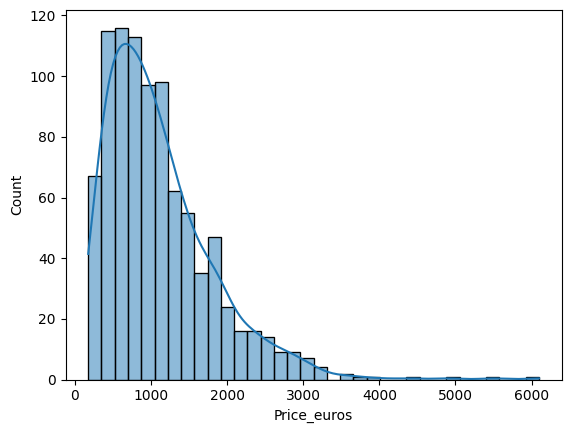

In [41]:
sns.histplot(df[target], kde = True)

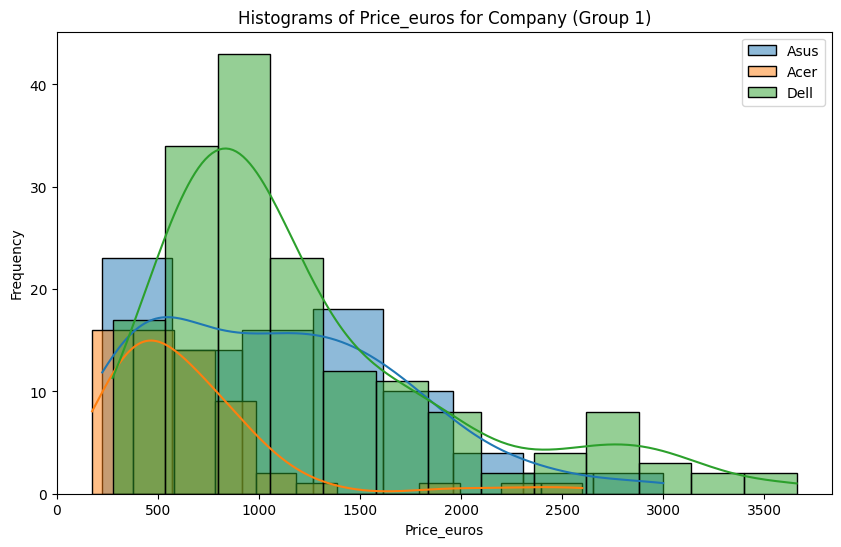

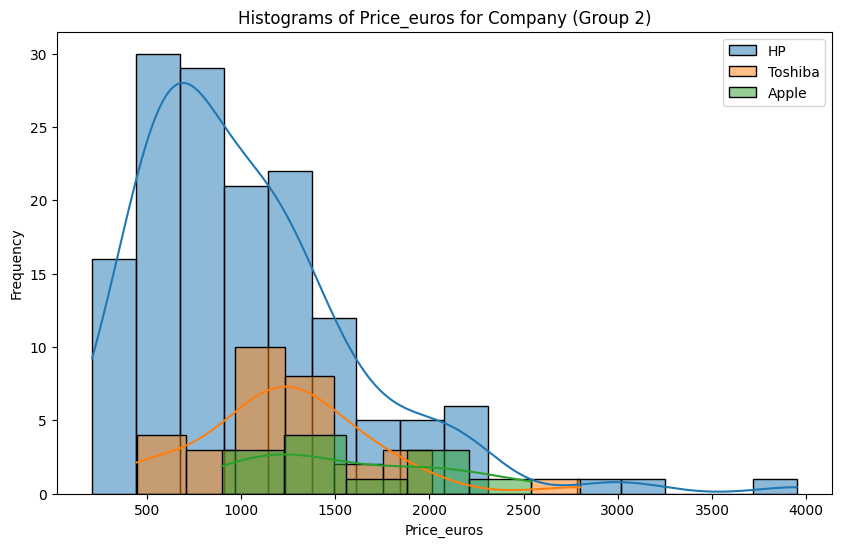

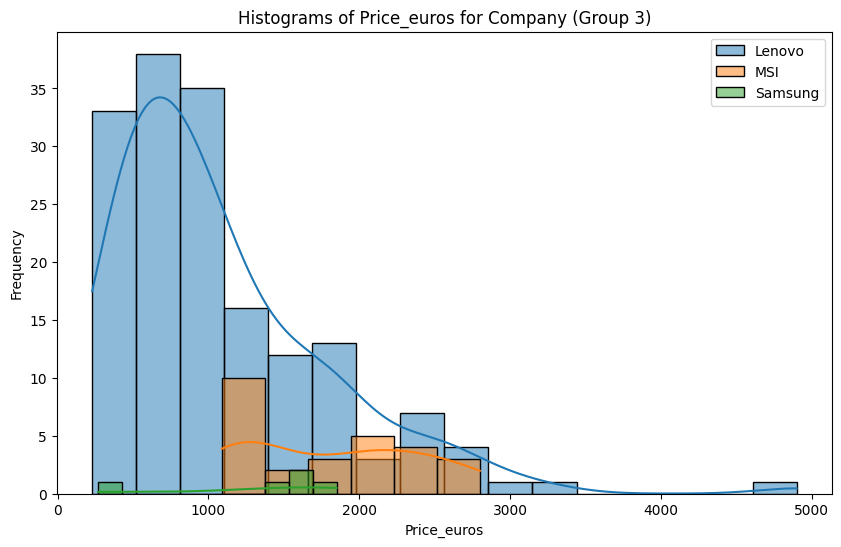

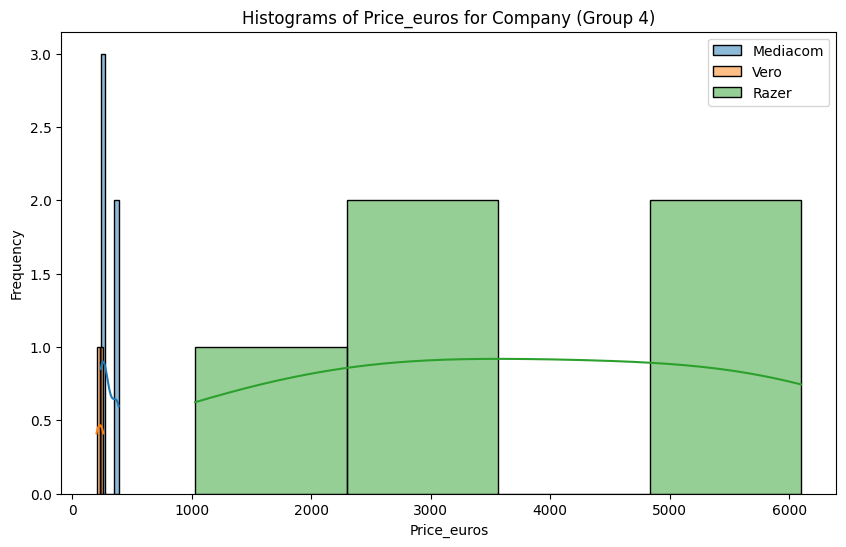

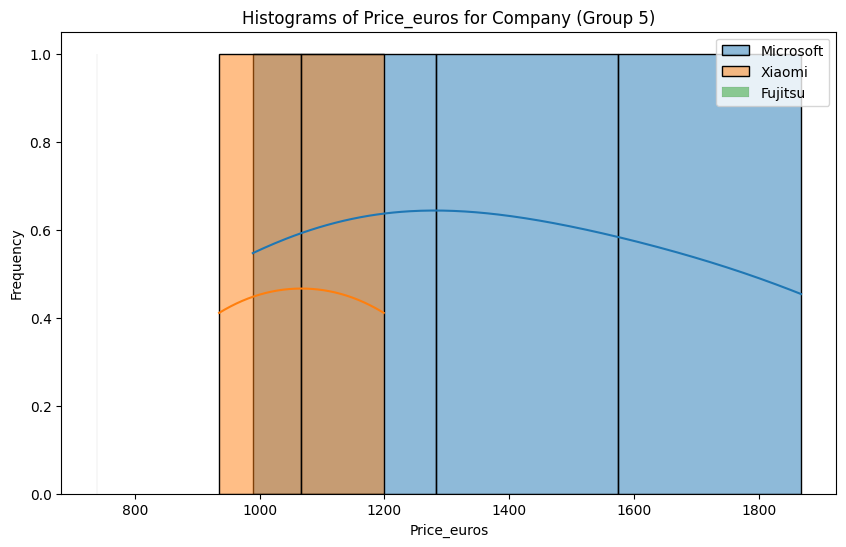

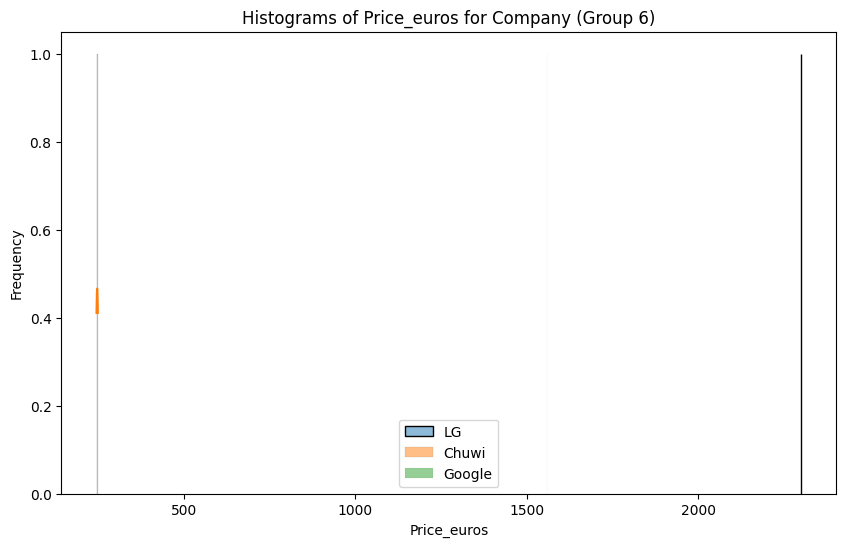

In [42]:
bt.plot_grouped_histograms(train_set, cat_col= "Company", num_col= target, group_size= 3)

In [43]:
train_set.head()

Company  TypeName  Inches  Ram  Weight  Price_euros  Capacity  \
25     Asus  Notebook    15.6  4.0    2.00        389.0    1000.0   
84     Acer  Notebook    15.6  4.0    2.10        451.0     256.0   
10     Asus  Notebook    15.6  4.0    2.65        309.0    1000.0   
342    Dell  Notebook    15.6  8.0    2.20        647.0    1000.0   
890      HP  Notebook    14.0  8.0    1.94        389.0    2000.0   

    Storage Type  Multiple Storage Marca CPU  GHz CPU Marca GPU  Panel Type  \
25           HDD             False     Intel      2.0     Intel       False   
84           SSD             False       AMD      3.0       AMD       False   
10           HDD             False     Intel      1.6     Intel       False   
342          HDD             False     Intel      1.6       AMD       False   
890          HDD             False     Intel      1.6     Intel       False   

     Quality  Touchscreen  
25   Full HD        False  
84      None        False  
10      None        False  
342  Full HD        False  
890     None        False

In [7]:
train_set = pd.get_dummies(train_set, dtype = int)
test_set = pd.get_dummies(test_set, dtype = int)

In [13]:
train_set = pd.get_dummies(train_set, columns = columnas_a_transformar, dtype = int)
test_set = pd.get_dummies(test_set, columns = columnas_a_transformar, dtype = int)

NameError: name 'columnas_a_transformar' is not defined

In [15]:
train_set

Inches   Ram  Weight  Price_euros  Company_Acer  Company_Apple  \
25     15.6   4.0    2.00        389.0             0              0   
84     15.6   4.0    2.10        451.0             1              0   
10     15.6   4.0    2.65        309.0             0              0   
342    15.6   8.0    2.20        647.0             0              0   
890    14.0   8.0    1.94        389.0             0              0   
..      ...   ...     ...          ...           ...            ...   
106    15.6   4.0    2.10        722.0             0              0   
270    17.3  16.0    4.14       2199.0             0              0   
860    14.0   4.0    1.48       1590.0             0              0   
435    15.6   8.0    2.65        999.0             0              0   
102    15.6  16.0    2.40       1799.0             0              0   

     Company_Asus  Company_Chuwi  Company_Dell  Company_Fujitsu  ...  \
25              1              0             0                0  ...   
84              0              0             0                0  ...   
10              1              0             0                0  ...   
342             0              0             1                0  ...   
890             0              0             0                0  ...   
..            ...            ...           ...              ...  ...   
106             0              0             0                0  ...   
270             0              0             0                0  ...   
860             0              0             0                0  ...   
435             0              0             1                0  ...   
102             0              0             0                0  ...   

     Gpu_Nvidia Quadro M620M  OpSys_Android  OpSys_Chrome OS  OpSys_Linux  \
25                         0              0                0            1   
84                         0              0                0            0   
10                         0              0                0            0   
342                        0              0                0            1   
890                        0              0                0            0   
..                       ...            ...              ...          ...   
106                        0              0                0            0   
270                        0              0                0            0   
860                        0              0                0            0   
435                        0              0                0            0   
102                        0              0                0            0   

     OpSys_Mac OS X  OpSys_No OS  OpSys_Windows 10  OpSys_Windows 10 S  \
25                0            0                 0                   0   
84                0            0                 1                   0   
10                0            0                 1                   0   
342               0            0                 0                   0   
890               0            0                 1                   0   
..              ...          ...               ...                 ...   
106               0            0                 1                   0   
270               0            0                 1                   0   
860               0            0                 1                   0   
435               0            0                 1                   0   
102               0            0                 1                   0   

     OpSys_Windows 7  OpSys_macOS  
25                 0            0  
84                 0            0  
10                 0            0  
342                0            0  
890                0            0  
..               ...          ...  
106                0            0  
270                0            0  
860                0            0  
435                0            0  
102                0            0  

[729 rows x 684 columns]

In [16]:
test_set

Inches   Ram  Weight  Price_euros  Company_Acer  Company_Apple  \
649    15.6  16.0    1.93      1426.66             0              0   
761    14.0   8.0    1.64      1049.26             0              0   
545    15.6   8.0    2.20       799.00             0              0   
367    13.3   8.0    1.60       999.00             1              0   
361    15.6   8.0    1.84      1389.00             0              0   
..      ...   ...     ...          ...           ...            ...   
344    15.6   8.0    2.20      1043.00             0              0   
581    15.6   6.0    2.04       539.00             0              0   
872    17.3   4.0    2.80       530.00             0              0   
449    17.3   8.0    2.70      1486.77             0              0   
789    17.3  16.0    3.00      4389.00             0              0   

     Company_Asus  Company_Dell  Company_Fujitsu  Company_Google  ...  \
649             0             1                0               0  ...   
761             0             0                0               0  ...   
545             0             0                1               0  ...   
367             0             0                0               0  ...   
361             0             0                0               0  ...   
..            ...           ...              ...             ...  ...   
344             0             0                0               0  ...   
581             0             0                0               0  ...   
872             1             0                0               0  ...   
449             0             0                0               0  ...   
789             0             0                0               0  ...   

     Gpu_Nvidia Quadro 3000M  Gpu_Nvidia Quadro M2000M  \
649                        0                         0   
761                        0                         0   
545                        0                         0   
367                        0                         0   
361                        0                         0   
..                       ...                       ...   
344                        0                         0   
581                        0                         0   
872                        0                         0   
449                        0                         0   
789                        0                         1   

     Gpu_Nvidia Quadro M520M  OpSys_Chrome OS  OpSys_Linux  OpSys_Mac OS X  \
649                        0                0            0               0   
761                        0                0            0               0   
545                        0                0            0               0   
367                        0                0            0               0   
361                        0                0            0               0   
..                       ...              ...          ...             ...   
344                        0                0            0               0   
581                        0                0            0               0   
872                        0                0            0               0   
449                        0                0            0               0   
789                        0                0            0               0   

     OpSys_No OS  OpSys_Windows 10  OpSys_Windows 7  OpSys_macOS  
649            0                 1                0            0  
761            0                 1                0            0  
545            0                 1                0            0  
367            0                 1                0            0  
361            0                 1                0            0  
..           ...               ...              ...          ...  
344            0                 1                0            0  
581            0                 1                0            0  
872            0                 1    

In [8]:
features_num = ['Weight','Inches','Ram']

In [47]:
features_num = ['Weight','Inches','Ram', 'Capacity','GHz CPU']

array([[<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Inches'}>],
       [<Axes: title={'center': 'Ram'}>, <Axes: >]], dtype=object)

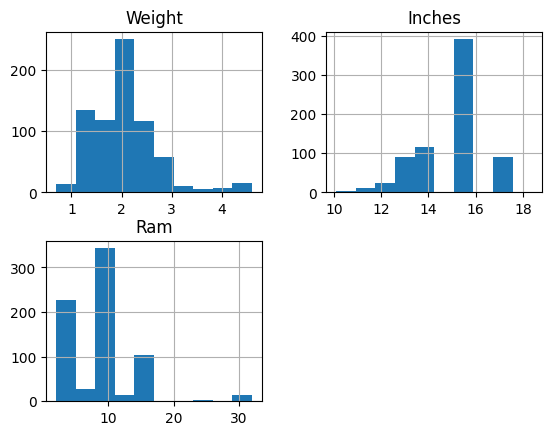

In [18]:
train_set[features_num].hist()

In [11]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

- Transformo la distribución de Capacity

In [50]:
test_set_scaled['Capacity'] = np.sqrt(test_set_scaled['Capacity']) 

In [51]:
train_set.head()

Inches  Ram  Weight  Price_euros  Capacity  GHz CPU  Company_Acer  \
25     15.6  4.0    2.00        389.0    1000.0      2.0             0   
84     15.6  4.0    2.10        451.0     256.0      3.0             1   
10     15.6  4.0    2.65        309.0    1000.0      1.6             0   
342    15.6  8.0    2.20        647.0    1000.0      1.6             0   
890    14.0  8.0    1.94        389.0    2000.0      1.6             0   

     Company_Apple  Company_Asus  Company_Chuwi  ...  Touchscreen_True  \
25               0             1              0  ...                 0   
84               0             0              0  ...                 0   
10               0             1              0  ...                 0   
342              0             0              0  ...                 0   
890              0             0              0  ...                 0   

     Storage Type_Flash Storage  Storage Type_HDD  \
25                            0                 1   
84                            0                 0   
10                            0                 1   
342                           0                 1   
890                           0                 1   

     Storage Type_HDD/Flash Storage  Storage Type_Hybrid  Storage Type_SSD  \
25                                0                    0                 0   
84                                0                    0                 1   
10                                0                    0                 0   
342                               0                    0                 0   
890                               0                    0                 0   

     Storage Type_SSD/HDD  Storage Type_SSD/Hybrid  Multiple Storage_False  \
25                      0                        0                       1   
84                      0                        0                       1   
10                      0                        0                       1   
342                     0                        0                       1   
890                     0                        0                       1   

     Multiple Storage_True  
25                       0  
84                       0  
10                       0  
342                      0  
890                      0  

[5 rows x 51 columns]

In [9]:
train_set[features_num]

Weight  Inches   Ram
25     2.00    15.6   4.0
84     2.10    15.6   4.0
10     2.65    15.6   4.0
342    2.20    15.6   8.0
890    1.94    14.0   8.0
..      ...     ...   ...
106    2.10    15.6   4.0
270    4.14    17.3  16.0
860    1.48    14.0   4.0
435    2.65    15.6   8.0
102    2.40    15.6  16.0

[729 rows x 3 columns]

In [12]:
scaler = StandardScaler()
train_set_scaled[features_num] = scaler.fit_transform(train_set[features_num])
test_set_scaled[features_num] = scaler.transform(test_set[features_num])

- Copia para tener las columnas originales y comparar con el test final

In [64]:
copia_train_scaled = train_set_scaled.copy()

- Puedo probar a crear las columas que falten rellenas de 0s, ya que puede haber marcas que no existan en el nuevo test con el modelo ya hecho

In [15]:
def igualar_columnas(df1,df2):
    set1 = set(df1)
    set2 = set(df2)
    diff1 = list(set1 - set2)
    diff2 = list(set2 - set1)

    df_faltantes_df1 = pd.DataFrame(columns=diff2)
    df_faltantes_df2 = pd.DataFrame(columns=diff1)

    df1_completo = pd.concat([df1, df_faltantes_df1], axis=1)
    df2_completo = pd.concat([df2, df_faltantes_df2], axis=1)
    df1_completo.fillna(0, inplace=True)
    df2_completo.fillna(0, inplace=True)

    return df1_completo, df2_completo
    

In [16]:
train_set, test_set = igualar_columnas(train_set, test_set)
train_set_scaled, test_set_scaled = igualar_columnas(train_set_scaled, test_set_scaled)

In [17]:
features_cat_encoded = train_set.columns[4:].copy()  # sin tratar columnas

In [57]:
features_cat_encoded = train_set.columns[6:].copy()
#features_cat_encoded_train = train_set.columns[6:].copy()
#features_cat_encoded_test = test_set.columns[6:].copy()

In [19]:
features_cat_encoded = train_set[features_cat_encoded].columns.to_list()
#features_cat_encoded_train = train_set[features_cat_encoded].columns.to_list()
#features_cat_encoded_test = test_set[features_cat_encoded_test].columns.to_list()

## COMPROBAR QUE TIENEN LAS MISMAS COLUMNAS (ver que haya ordenadores con valores muy poco comunes que hagan que el train y test sean distintos)

### 3. Crear y entrenar el modelo


In [22]:
train_set_scaled

Inches       Ram    Weight  Price_euros  Company_Acer  Company_Apple  \
25   0.378771 -0.849979 -0.091421        389.0             0              0   
84   0.378771 -0.849979  0.058967        451.0             1              0   
10   0.378771 -0.849979  0.886100        309.0             0              0   
342  0.378771 -0.070564  0.209355        647.0             0              0   
890 -0.783550 -0.070564 -0.181654        389.0             0              0   
..        ...       ...       ...          ...           ...            ...   
106  0.378771 -0.849979  0.058967        722.0             0              0   
270  1.613737  1.488265  3.126877       2199.0             0              0   
860 -0.783550 -0.849979 -0.873437       1590.0             0              0   
435  0.378771 -0.070564  0.886100        999.0             0              0   
102  0.378771  1.488265  0.510130       1799.0             0              0   

     Company_Asus  Company_Chuwi  Company_Dell  Company_Fujitsu  ...  \
25              1              0             0                0  ...   
84              0              0             0                0  ...   
10              1              0             0                0  ...   
342             0              0             1                0  ...   
890             0              0             0                0  ...   
..            ...            ...           ...              ...  ...   
106             0              0             0                0  ...   
270             0              0             0                0  ...   
860             0              0             0                0  ...   
435             0              0             1                0  ...   
102             0              0             0                0  ...   

     Product_X541NA-GO020T (N3350/4GB/1TB/W10)  Product_Inspiron 3168  \
25                                           0                      0   
84                                           0                      0   
10                                           0                      0   
342                                          0                      0   
890                                          0                      0   
..                                         ...                    ...   
106                                          0                      0   
270                                          0                      0   
860                                          0                      0   
435                                          0                      0   
102                                          0                      0   

     Product_GE73VR 7RE  Product_Zbook 17  Product_Pro P2540UA-XO0198T  \
25                    0                 0                            0   
84                    0                 0                            0   
10                    0                 0                            0   
342                   0                 0                            0   
890                   0                 0                            0   
..                  ...               ...                          ...   
106                   0                 0                            0   
270                   0                 0                            0   
860                   0                 0                            0   
435                   0                 0                            0   
102                   0                 0                            0   

     Product_Ideapad 700-15ISK  Cpu_AMD E-Series E2-6110 1.5GHz  \
25                           0                                0   
84                           0                                0   
10                           0                                0   
342                          0                                0   
890                          0                                0   
..                       

In [23]:
test_set_scaled.columns

Index(['Inches', 'Ram', 'Weight', 'Price_euros', 'Company_Acer',
       'Company_Apple', 'Company_Asus', 'Company_Dell', 'Company_Fujitsu',
       'Company_Google',
       ...
       'Product_Aspire ES1-533', 'Product_V310-15IKB (i5-7200U/4GB/1TB/No',
       'Gpu_Intel HD Graphics 510',
       'Product_FX753VD-GC086T (i5-7300HQ/8GB/1TB', 'Product_Yoga 720-13IKB',
       'Product_Omen 17-W006na', 'Cpu_Intel Core i7 2.2GHz',
       'Cpu_AMD A6-Series 9220 2.5GHz',
       'Product_15-bs025nv (i5-7200U/8GB/256GB/W10)', 'Cpu_AMD FX 9830P 3GHz'],
      dtype='object', length=779)

In [61]:
'''
set1 = set(features_cat_encoded_train)
set2 = set(features_cat_encoded_test)

diff1 = set1 - set2
diff2 = set2 - set1

columns_to_drop = ['Company_Chuwi',
 'Company_LG',
 'Company_Microsoft',
 'OpSys_Android',
 'OpSys_Windows 10 S',
 'Resolution_1440x900',
 'Resolution_1920x1200',
 'Resolution_2256x1504',
 'Storage Type_HDD/Flash Storage',
 'Storage Type_Hybrid',
 'Storage Type_SSD/Hybrid']
train_set.drop(columns=columns_to_drop, inplace=True)
train_set_scaled.drop(columns=columns_to_drop, inplace=True)

columns_to_drop = ['Company_Huawei', 'Resolution_2160x1440']
test_set.drop(columns=columns_to_drop, inplace=True)
test_set_scaled.drop(columns=columns_to_drop, inplace=True)
'''

"\nset1 = set(features_cat_encoded_train)\nset2 = set(features_cat_encoded_test)\n\ndiff1 = set1 - set2\ndiff2 = set2 - set1\n\ncolumns_to_drop = ['Company_Chuwi',\n 'Company_LG',\n 'Company_Microsoft',\n 'OpSys_Android',\n 'OpSys_Windows 10 S',\n 'Resolution_1440x900',\n 'Resolution_1920x1200',\n 'Resolution_2256x1504',\n 'Storage Type_HDD/Flash Storage',\n 'Storage Type_Hybrid',\n 'Storage Type_SSD/Hybrid']\ntrain_set.drop(columns=columns_to_drop, inplace=True)\ntrain_set_scaled.drop(columns=columns_to_drop, inplace=True)\n\ncolumns_to_drop = ['Company_Huawei', 'Resolution_2160x1440']\ntest_set.drop(columns=columns_to_drop, inplace=True)\ntest_set_scaled.drop(columns=columns_to_drop, inplace=True)\n"

In [59]:
features_cat_encoded

Index(['Company_Acer', 'Company_Apple', 'Company_Asus', 'Company_Chuwi',
       'Company_Dell', 'Company_Fujitsu', 'Company_Google', 'Company_HP',
       'Company_LG', 'Company_Lenovo',
       ...
       'Gpu_Nvidia Quadro M620M', 'OpSys_Android', 'OpSys_Chrome OS',
       'OpSys_Linux', 'OpSys_Mac OS X', 'OpSys_No OS', 'OpSys_Windows 10',
       'OpSys_Windows 10 S', 'OpSys_Windows 7', 'OpSys_macOS'],
      dtype='object', length=274)

In [20]:
X_train = train_set[features_cat_encoded + features_num].copy()
X_train_scaled = train_set_scaled[features_cat_encoded + features_num].copy()
y_train = train_set[target]
X_test = test_set[features_cat_encoded + features_num].copy()
X_test_scaled = test_set_scaled[features_cat_encoded + features_num].copy()
y_test = test_set[target]

In [64]:
train_set.head()

Inches  Ram  Weight  Price_euros  Capacity  GHz CPU  Company_Acer  \
25     15.6  4.0    2.00        389.0    1000.0      2.0             0   
84     15.6  4.0    2.10        451.0     256.0      3.0             1   
10     15.6  4.0    2.65        309.0    1000.0      1.6             0   
342    15.6  8.0    2.20        647.0    1000.0      1.6             0   
890    14.0  8.0    1.94        389.0    2000.0      1.6             0   

     Company_Apple  Company_Asus  Company_Chuwi  ...  \
25               0             1              0  ...   
84               0             0              0  ...   
10               0             1              0  ...   
342              0             0              0  ...   
890              0             0              0  ...   

     Storage Type_Flash Storage  Storage Type_HDD  \
25                            0                 1   
84                            0                 0   
10                            0                 1   
342                           0                 1   
890                           0                 1   

     Storage Type_HDD/Flash Storage  Storage Type_Hybrid  Storage Type_SSD  \
25                                0                    0                 0   
84                                0                    0                 1   
10                                0                    0                 0   
342                               0                    0                 0   
890                               0                    0                 0   

     Storage Type_SSD/HDD  Storage Type_SSD/Hybrid  Multiple Storage_False  \
25                      0                        0                       1   
84                      0                        0                       1   
10                      0                        0                       1   
342                     0                        0                       1   
890                     0                        0                       1   

     Multiple Storage_True  Company_Huawei  
25                       0               0  
84                       0               0  
10                       0               0  
342                      0               0  
890                      0               0  

[5 rows x 52 columns]

In [21]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42)
rf_reg_2 = RandomForestRegressor(max_depth = 10, random_state= 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)
lgb_reg_2 = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)

modelos_reg = {
    "Random Forest": rf_reg,
    "LightGBM": lgb_reg,
    "XGBoost Regressor": xgb_reg
}

In [27]:
print(-np.mean(cross_val_score(rf_reg, X_train_scaled, y_train, cv = 5, scoring = "neg_mean_absolute_percentage_error")).round(3))

0.199


In [32]:
print(-np.mean(cross_val_score(lgb_reg, X_train_scaled, y_train, cv = 5, scoring = "neg_mean_absolute_percentage_error")).round(3))

[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/sklearn.py", line 1092, in fit
    super().fit(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/sklearn.py", line 885, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/engine.py", line 255, in train
    booster = Booster(params=params, train_set=train_set)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/basic.py", line 3433, in __init__
    train_set.construct()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/basic.py", line 2462, in construct
    self._lazy_init(data=self.data, label=self.label, reference=None,
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/basic.py", line 2123, in _lazy_init
    return self.set_feature_name(feature_name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/basic.py", line 2863, in set_feature_name
    _safe_call(_LIB.LGBM_DatasetSetFeatureNames(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/basic.py", line 263, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode('utf-8'))
lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name.


In [33]:
print(-np.mean(cross_val_score(xgb_reg, X_train_scaled, y_train, cv = 5, scoring = "neg_mean_absolute_percentage_error")).round(3))

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 1588, in _init
    it.reraise()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 576, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
           ^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 633, in input_data
    self.proxy.set_info(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 946, in set_info
    self.feature_names = feature_names
    ^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 1322, in feature_names
    raise ValueError(
ValueError: feature_names must be string, and may not contain [, ] or <


### 4. Sacar métricas, valorar el modelo 

Recuerda que en la competición se va a evaluar con la métrica de MAE.

In [125]:
param_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [5,10,20],
    "max_features": ["log2","sqrt",None],
    'min_samples_leaf':[10,20,50,100],

}

lgb_grid = GridSearchCV(lgb_reg,
                        param_grid= param_grid,
                        cv = 5,
                        scoring = "neg_mean_absolute_percentage_error")

lgb_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LGBMRegressor(max_depth=10, random_state=42,
                                     verbose=-100),
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'n_estimators': [100, 200, 400]},
             scoring='neg_mean_absolute_percentage_error')

In [126]:
print(lgb_grid.best_params_)

{'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 200}


In [127]:
print(lgb_grid.best_score_.round(4))

-0.1965


In [135]:
params = {
    'objective': 'regression',
    'metric': 'mse'
}
num_round = 100
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_test])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 729, number of used features: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1122.043223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [136]:
feature_importances = pd.DataFrame({"features": rf_best.feature_names_in_, "importance": bst.feature_importance(importance_type='gain')}).sort_values("importance",ascending = False)
feature_importances.sort_values('importance',ascending=False,inplace=True)

In [139]:
feature_importances[feature_importances['importance'] > 0.1]

features    importance
48                          Ram  9.460746e+08
46                       Weight  2.932847e+08
50                      GHz CPU  1.636124e+08
21            TypeName_Notebook  1.119451e+08
31          Quality_4K Ultra HD  1.107046e+08
37             Storage Type_HDD  3.774098e+07
32              Quality_Full HD  3.014165e+07
49                     Capacity  2.795685e+07
19              TypeName_Gaming  2.351908e+07
47                       Inches  1.855923e+07
7                    Company_HP  1.775037e+07
29             Panel Type_False  1.617946e+07
24                Marca CPU_AMD  7.709596e+06
4                  Company_Dell  6.571383e+06
34            Touchscreen_False  6.144198e+06
40             Storage Type_SSD  5.511153e+06
2                  Company_Asus  5.150770e+06
0                  Company_Acer  5.068969e+06
9                Company_Lenovo  4.124689e+06
26                Marca GPU_AMD  3.109467e+06
28             Marca GPU_Nvidia  2.875194e+06
43       Multiple Storage_False  2.507770e+06
27              Marca GPU_Intel  1.702371e+06
22           TypeName_Ultrabook  1.327828e+06
18  TypeName_2 in 1 Convertible  1.190658e+06
15              Company_Toshiba  1.061909e+06
41         Storage Type_SSD/HDD  1.860798e+05
36   Storage Type_Flash Storage  1.021070e+04

In [140]:
features_importantes = list(feature_importances[feature_importances['importance'] > 0.001]['features'])
X_train_importante = train_set[features_importantes].copy()
X_train_scaled_importante = train_set_scaled[features_importantes].copy()
X_test_importante = test_set[features_importantes].copy()
X_test_scaled_importante = test_set_scaled[features_importantes].copy()

In [1375]:
len(X_train_scaled.columns)

51

In [142]:
lgb_reg.booster_.feature_importance(importance_type='gain')

NotFittedError: No booster found. Need to call fit beforehand.

In [1403]:
importance_gain

array([5.59066071e+06, 0.00000000e+00, 4.94905400e+06, 0.00000000e+00,
       5.96961540e+06, 0.00000000e+00, 0.00000000e+00, 1.75931505e+07,
       0.00000000e+00, 3.36723781e+06, 8.94113008e+04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.87257000e+05,
       0.00000000e+00, 0.00000000e+00, 1.54883380e+06, 2.16290281e+07,
       0.00000000e+00, 1.11464007e+08, 1.81681221e+06, 0.00000000e+00,
       7.84416000e+06, 0.00000000e+00, 2.21772890e+06, 1.96333016e+06,
       2.62529579e+06, 1.46841792e+07, 0.00000000e+00, 1.12537942e+08,
       2.85970124e+07, 0.00000000e+00, 4.84191780e+06, 0.00000000e+00,
       0.00000000e+00, 3.72230471e+07, 0.00000000e+00, 0.00000000e+00,
       5.61284140e+06, 7.36716600e+05, 0.00000000e+00, 2.41697820e+06,
       0.00000000e+00, 0.00000000e+00, 2.89568388e+08, 1.98146819e+07,
       9.47423096e+08, 2.59449830e+07, 1.60616049e+08])

In [1376]:
# Predecir usando el mejor modelo
predictions = lgb_reg.predict(X_test_scaled, num_iteration=best_iteration)
print("Predicciones:", predictions)

Predicciones: [2004.02128151 1120.32790526  795.54513486  706.03043856 1965.46497181
  509.62898802  594.05827889  289.89859242  355.07887782  855.60669442
  319.14901233 1639.06353972  630.54111261 1500.99315038  504.33222336
 1537.07594736  535.32051951 1543.13167975  523.14551229  834.86710464
  343.00375594 1051.11146837 1296.20577882  419.33722601 1014.14655803
  619.32266836 1207.88217277 1359.56196071 1194.8608975  1593.48819737
 1341.04768961 2457.00123869  407.00288891  758.37272195  354.96287101
  406.38267642  248.60034468 2863.86666245 1374.97861401 2885.35160096
 1108.41948526  696.9561424  2307.87167904  283.45197851  347.25184229
  385.81107132 1630.58917053  484.7114633   797.58521796 1310.26145408
 1407.87587822 1956.00122218  782.54350572 1267.83389528  860.16235569
  766.44663121  343.59521847  650.05600011  870.75213798 1585.92128671
 1691.20215816  651.06389385  832.56417524  965.8039495  1666.19676123
 1328.48753729 1424.70468824  404.11512378 1005.81689811  734.9

In [1377]:
y_pred = lgb_grid.best_estimator_.predict(X_test_scaled)

In [1378]:
print("MAE:", median_absolute_error(y_test, y_pred))

MAE: 108.97569814943131


In [144]:
param_grid = {
    "n_estimators": [100,200],
    "max_depth": [5,10,20],
    "max_features": ["log2","sqrt",None],
    'min_samples_leaf':[10,20,50,100],

}

lgb_grid_2 = GridSearchCV(lgb_reg,
                        param_grid= param_grid,
                        cv = 5,
                        scoring = "neg_mean_absolute_percentage_error")

lgb_grid_2.fit(X_train_scaled_importante, y_train)

GridSearchCV(cv=5,
             estimator=LGBMRegressor(max_depth=10, random_state=42,
                                     verbose=-100),
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_percentage_error')

In [145]:
print(lgb_grid_2.best_params_)

{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 200}


In [146]:
print(lgb_grid_2.best_score_.round(4))

-0.1951


In [147]:
y_pred = lgb_grid_2.best_estimator_.predict(X_test_scaled_importante)
print("MAE:", median_absolute_error(y_test, y_pred))

MAE: 121.57098902288112


In [161]:
lgb_reg.fit(
    X_train_scaled_importante, y_train,
)

LGBMRegressor(max_depth=10, random_state=42, verbose=-100)

In [22]:
param_grid = {
    "n_estimators": [100,200],
    "max_depth": [5,10,20],
    "max_features": ["log2","sqrt",None],
    'min_samples_leaf':[10,20,50,100],

}

rf_grid = GridSearchCV(rf_reg,
                        param_grid= param_grid,
                        cv = 5,
                        scoring = "neg_mean_absolute_percentage_error")

rf_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=10, random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_percentage_error')

In [23]:
print(rf_grid.best_params_)

{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 100}


In [24]:
print(rf_grid.best_score_.round(4))

-0.2704


In [25]:
rf_reg.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [39]:
rf_best = rf_grid.best_estimator_

In [40]:
feature_importances = pd.DataFrame({"features": rf_best.feature_names_in_, "importance": rf_best.feature_importances_}).sort_values("importance",ascending = False)
feature_importances.sort_values('importance',ascending=False,inplace=True)

In [41]:
feature_importances[feature_importances['importance'] > 0.001]

features  importance
777                                           Ram    0.659075
427                             TypeName_Notebook    0.120034
775                                        Weight    0.096183
429                          TypeName_Workstation    0.015226
580                              Memory_512GB SSD    0.012831
562                                Memory_1TB HDD    0.010926
7                                      Company_HP    0.010455
648                   Gpu_Nvidia GeForce GTX 1070    0.008169
430                     ScreenResolution_1366x768    0.008085
519                Cpu_Intel Core i5 7200U 2.5GHz    0.007674
776                                        Inches    0.007557
644                   Gpu_Nvidia GeForce GTX 1050    0.005162
515                Cpu_Intel Core i5 6200U 2.3GHz    0.005121
568                              Memory_256GB SSD    0.005022
626                     Gpu_Intel HD Graphics 620    0.003690
438            ScreenResolution_Full HD 1920x1080    0.003122
540               Cpu_Intel Core i7 7700HQ 2.8GHz    0.002469
4                                    Company_Dell    0.002146
444  ScreenResolution_IPS Panel Full HD 1920x1080    0.001962
676                              OpSys_Windows 10    0.001817
570                   Memory_256GB SSD +  1TB HDD    0.001633
425                               TypeName_Gaming    0.001619
623                     Gpu_Intel HD Graphics 520    0.001395
9                                  Company_Lenovo    0.001343
616                         Gpu_Intel HD Graphics    0.001219

In [107]:
features_importantes = list(feature_importances[feature_importances['importance'] > 0.001]['features'])

In [108]:

X_train_importante = train_set[features_importantes].copy()
X_train_scaled_importante = train_set_scaled[features_importantes].copy()
X_test_importante = test_set[features_importantes].copy()
X_test_scaled_importante = test_set_scaled[features_importantes].copy()

In [109]:
X_train_importante

Ram  TypeName_Notebook  Weight  GHz CPU  Storage Type_HDD  \
25    4.0                  1    2.00      2.0                 1   
84    4.0                  1    2.10      3.0                 0   
10    4.0                  1    2.65      1.6                 1   
342   8.0                  1    2.20      1.6                 1   
890   8.0                  1    1.94      1.6                 1   
..    ...                ...     ...      ...               ...   
106   4.0                  1    2.10      1.6                 1   
270  16.0                  0    4.14      2.7                 0   
860   4.0                  1    1.48      2.5                 0   
435   8.0                  0    2.65      2.5                 1   
102  16.0                  0    2.40      2.8                 0   

     Quality_Full HD  TypeName_Workstation  Capacity  TypeName_Gaming  Inches  \
25                 1                     0    1000.0                0    15.6   
84                 0                     0     256.0                0    15.6   
10                 0                     0    1000.0                0    15.6   
342                1                     0    1000.0                0    15.6   
890                0                     0    2000.0                0    14.0   
..               ...                   ...       ...              ...     ...   
106                1                     0     500.0                0    15.6   
270                1                     0    1128.0                1    17.3   
860                1                     0     256.0                0    14.0   
435                1                     0    1000.0                1    15.6   
102                1                     0    1256.0                1    15.6   

     Company_HP  Quality_4K Ultra HD  Marca GPU_Intel  Panel Type_True  \
25            0                    0                1                0   
84            0                    0                0                0   
10            0                    0                1                0   
342           0                    0                0                0   
890           1                    0                1                0   
..          ...                  ...              ...              ...   
106           1                    0                1                1   
270           0                    0                0                0   
860           1                    0                1                0   
435           0                    0                0                0   
102           0                    0                0                1   

     Storage Type_SSD  Panel Type_False  Marca GPU_Nvidia  
25                  0                 1                 0  
84                  1                 1                 0  
10                  0                 1                 0  
342                 0                 1                 0  
890                 0                 1                 0  
..                ...               ...               ...  
106                 0                 0                 0  
270                 0                 1                 1  
860                 1                 1                 0  
435                 0                 1                 1  
102                 0                 0                 1  

[729 rows x 17 columns]

In [110]:
param_grid = {
    "n_estimators": [100,200],
    "max_depth": [5,10,20],
    "max_features": ["log2","sqrt",None],
    'min_samples_leaf':[10,20,50,100],

}

rf_grid_2 = GridSearchCV(rf_reg_2,
                        param_grid= param_grid,
                        cv = 5,
                        scoring = "neg_mean_absolute_percentage_error")

rf_grid.fit(X_train_scaled_importante, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=10, random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_percentage_error')

In [111]:
print(rf_grid_2.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [112]:
rf_reg_2.fit(X_train_scaled_importante, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [26]:
y_pred = rf_grid.best_estimator_.predict(X_test_scaled)
print("MAE:", median_absolute_error(y_test, y_pred))

MAE: 172.57526095319645


In [86]:
param_grid = {
    "n_estimators": [100,200],
    "max_depth": [5,10,20],
    "max_features": ["log2","sqrt",None],
    'min_samples_leaf':[10,20,50,100],

}

xgb_grid = GridSearchCV(xgb_reg,
                        param_grid= param_grid,
                        cv = 5,
                        scoring = "neg_mean_absolute_percentage_error")

xgb_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=10, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_percentage_error')

In [87]:
print(xgb_grid.best_params_)

{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 100}


In [88]:
print(xgb_grid.best_score_.round(4))

-0.1769


In [89]:
y_pred = xgb_grid.best_estimator_.predict(X_test_scaled)
print("MAE:", median_absolute_error(y_test, y_pred))

MAE: 117.5745849609375


-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir con el dataset de predicción 

Definición de **modelo que está listo**. 

Tras hacer suficientes pruebas, analizar los datos, hacer feature engineering, probar diferentes modelos con diferentes parámetros, es con este con el que observo mejores métricas y menos overfitting. ¡Cuidado con el overfitting aquí! Si vuestro modelo aprende muy bien de estos datos pero hay overfitting cuando le pasemos los datos desconocidos de `test.csv` nos arriesgamos a que digamos, no salga lo esperado.

### 1. Entrena dicho modelo con TODOS tus datos de train, esto es con `train.csv` al completo.


**CON LAS TRANSFORMACIONES QUE LE HAYAS REALIZADO A `X` INCLUÍDAS.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 2. Carga los datos de `test.csv` para predecir.

In [56]:
test = pd.read_csv("./data/test.csv")

- Aplico todos los cambios al nuevo test

In [32]:
test.columns

Index(['id', 'laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight'],
      dtype='object')

In [57]:
test.Weight = test.Weight.str.replace('kg','',regex=False)
test.Weight = test.Weight.astype(float)
test.Ram = test.Ram.str.replace('GB','',regex=False)
test.Ram = test.Ram.astype(float)

In [60]:
test.drop(columns=['id','laptop_ID', 'Product'], inplace=True)

In [150]:
test[['Capacity', 'Storage Type', 'Multiple Storage']] = test['Memory'].apply(decompose_info)

In [151]:
test[['Marca CPU', 'GHz CPU', 'Modelo CPU']] = test['Cpu'].apply(split_info)
test[['Marca GPU', 'Modelo GPU']] = test['Gpu'].apply(split_info_2)
test[['Resolution', 'Panel Type', 'Quality', 'Touchscreen']] = test['ScreenResolution'].apply(decompose_info_2)

test['GHz CPU'] = test['GHz CPU'].str.replace('GHz','',regex=False)
test['GHz CPU'] = test['GHz CPU'].astype(float)

test = test.drop(['ScreenResolution', 'Cpu', 'Modelo CPU', 'Modelo GPU','Memory', 'Gpu', 'Product', 'OpSys', 'Resolution'], axis = 1)
test = pd.get_dummies(test, columns = columnas_a_transformar, dtype = int)
test_scaled = test.copy()
test_scaled[features_num] = scaler.transform(test_scaled[features_num])
test_scaled['Capacity'] = np.sqrt(test['Capacity']) 

copia_train_scaled, test_scaled = igualar_columnas(train_set_scaled, test_scaled)

In [61]:
test = pd.get_dummies(test, dtype = int)
test_scaled = test.copy()
test_scaled[features_num] = scaler.transform(test_scaled[features_num])

In [68]:
copia_train_scaled, test_scaled = igualar_columnas(train_set_scaled, test_scaled)

In [71]:
features_cat_encoded_test_final = test_scaled.columns[3:].copy().tolist()

In [42]:
copia_train_scaled

Inches       Ram    Weight  Price_euros  Company_Acer  Company_Apple  \
25   0.378771 -0.849979 -0.091421        389.0             0              0   
84   0.378771 -0.849979  0.058967        451.0             1              0   
10   0.378771 -0.849979  0.886100        309.0             0              0   
342  0.378771 -0.070564  0.209355        647.0             0              0   
890 -0.783550 -0.070564 -0.181654        389.0             0              0   
..        ...       ...       ...          ...           ...            ...   
106  0.378771 -0.849979  0.058967        722.0             0              0   
270  1.613737  1.488265  3.126877       2199.0             0              0   
860 -0.783550 -0.849979 -0.873437       1590.0             0              0   
435  0.378771 -0.070564  0.886100        999.0             0              0   
102  0.378771  1.488265  0.510130       1799.0             0              0   

     Company_Asus  Company_Chuwi  Company_Dell  Company_Fujitsu  ...  \
25              1              0             0                0  ...   
84              0              0             0                0  ...   
10              1              0             0                0  ...   
342             0              0             1                0  ...   
890             0              0             0                0  ...   
..            ...            ...           ...              ...  ...   
106             0              0             0                0  ...   
270             0              0             0                0  ...   
860             0              0             0                0  ...   
435             0              0             1                0  ...   
102             0              0             0                0  ...   

     Product_Rog GL753VE-GC070T  Product_Aspire E5-575  \
25                            0                      0   
84                            0                      0   
10                            0                      0   
342                           0                      0   
890                           0                      0   
..                          ...                    ...   
106                           0                      0   
270                           0                      0   
860                           0                      0   
435                           0                      0   
102                           0                      0   

     Product_R558UA-DM966T (i5-7200U/8GB/128GB/FHD/W10)  Product_Spectre Pro  \
25                                                   0                     0   
84                                                   0                     0   
10                                                   0                     0   
342                                                  0                     0   
890                                                  0                     0   
..                                                 ...                   ...   
106                                                  0                     0   
270                                                  0                     0   
860                                                  0                     0   
435                                                  0                     0   
102                                                  0                     0   

     Product_ProBook 650  Product_15-BS078nr (i7-7500U/8GB/1TB/W10)  \
25                     0                                          0   
84                     0                                          0   
10                     0                                          0   
342                    0                                          0   
890                    0                                          0   
..                   ...                                        ...   
106                    0              

In [70]:
test_scaled

Inches       Ram    Weight  Company_Acer  Company_Apple  Company_Asus  \
0   -1.292066  1.488265 -1.144135             0              0             0   
1    0.378771 -0.070564  0.209355             1              0             0   
2    0.378771 -0.849979  0.510130             1              0             0   
3   -0.783550 -0.070564 -0.948631             0              0             0   
4   -1.292066 -0.070564 -1.083980             0              0             0   
..        ...       ...       ...           ...            ...           ...   
386  0.378771 -0.070564  0.510130             0              0             0   
387  0.378771  1.488265  1.878659             0              0             0   
388  0.378771 -0.849979 -0.151576             0              0             0   
389  0.378771 -0.849979  0.058967             0              0             0   
390 -0.856196 -0.070564 -1.038864             0              0             0   

     Company_Chuwi  Company_Dell  Company_Google  Company_HP  ...  \
0                0             0               0           1  ...   
1                0             0               0           0  ...   
2                0             0               0           0  ...   
3                0             0               0           1  ...   
4                0             0               0           1  ...   
..             ...           ...             ...         ...  ...   
386              0             0               0           0  ...   
387              0             0               0           0  ...   
388              0             0               0           1  ...   
389              0             0               0           1  ...   
390              0             0               0           0  ...   

     Cpu_Intel Pentium Dual Core 4405U 2.1GHz  Cpu_Intel Atom Z8350 1.92GHz  \
0                                           0                             0   
1                                           0                             0   
2                                           0                             0   
3                                           0                             0   
4                                           0                             0   
..                                        ...                           ...   
386                                         0                             0   
387                                         0                             0   
388                                         0                             0   
389                                         0                             0   
390                                         0                             0   

     Cpu_AMD E-Series 9000 2.2GHz  \
0                               0   
1                               0   
2                               0   
3                               0   
4                               0   
..                            ...   
386                             0   
387                             0   
388                             0   
389                             0   
390                             0   

     ScreenResolution_IPS Panel Full HD 1920x1200  Cpu_AMD Ryzen 1600 3.2GHz  \
0                                               0                          0   
1                                               0                          0   
2                                               0                          0   
3                                               0                          0   
4                                               0                          0   
..                                            ...                        ...   
386                                             0                          0   
387                                             0                          0   
388                                             0                          0   
389                    

In [1645]:
features_cat_encoded_test_final = test_scaled.columns[7:].copy().tolist()

In [154]:
test_scaled[features_importantes]

Ram    Weight   GHz CPU  TypeName_Notebook  Quality_4K Ultra HD  \
0    1.488265 -1.144135  0.765695                  0                    1   
1   -0.070564  0.209355  0.765695                  1                    0   
2   -0.849979  0.510130 -0.626006                  1                    0   
3   -0.070564 -0.948631 -0.029563                  1                    0   
4   -0.070564 -1.083980  0.368066                  1                    0   
..        ...       ...       ...                ...                  ...   
386 -0.070564  0.510130  0.964509                  0                    0   
387  1.488265  1.878659  0.566880                  0                    0   
388 -0.849979 -0.151576  0.368066                  1                    0   
389 -0.849979  0.058967 -1.620079                  1                    0   
390 -0.070564 -1.038864 -1.023635                  0                    0   

     Storage Type_HDD  Quality_Full HD   Capacity  TypeName_Gaming    Inches  \
0                   0                0  22.627417                0 -1.292066   
1                   0                0  16.000000                0  0.378771   
2                   1                0  22.360680                0  0.378771   
3                   0                1  16.000000                0 -0.783550   
4                   0                1  16.000000                0 -1.292066   
..                ...              ...        ...              ...       ...   
386                 0                1  16.000000                1  0.378771   
387                 0                1  22.627417                1  0.378771   
388                 1                0  22.360680                0  0.378771   
389                 1                1  22.360680                0  0.378771   
390                 0                1  22.627417                0 -0.856196   

     ...  Company_Lenovo  Marca GPU_AMD  Marca GPU_Nvidia  \
0    ...               0              0                 0   
1    ...               0              1                 0   
2    ...               0              0                 0   
3    ...               0              0                 0   
4    ...               0              0                 0   
..   ...             ...            ...               ...   
386  ...               1              0                 1   
387  ...               1              0                 1   
388  ...               0              0                 0   
389  ...               0              1                 0   
390  ...               1              0                 0   

     Multiple Storage_False  Marca GPU_Intel  TypeName_Ultrabook  \
0                         1                1                   1   
1                         1                0                   0   
2                         1                1                   0   
3                         1                1                   0   
4                         1                1                   0   
..                      ...              ...                 ...   
386                       1                0                   0   
387                       1                0                   0   
388                       1                1                   0   
389                       1                0                   0   
390                       1                1                   0   

     TypeName_2 in 1 Convertible  Company_Toshiba  Storage Type_SSD/HDD  \
0                              0                0                     0   
1                              0                0                     0   
2                              0                0                     0   
3                              0                0                     0   
4                              0                0                     0   
..                           ...              ...                   ...   
386                            0                0

In [155]:
test_final_importante = test_scaled[features_importantes].copy()

In [156]:
test_final_importante

Ram    Weight   GHz CPU  TypeName_Notebook  Quality_4K Ultra HD  \
0    1.488265 -1.144135  0.765695                  0                    1   
1   -0.070564  0.209355  0.765695                  1                    0   
2   -0.849979  0.510130 -0.626006                  1                    0   
3   -0.070564 -0.948631 -0.029563                  1                    0   
4   -0.070564 -1.083980  0.368066                  1                    0   
..        ...       ...       ...                ...                  ...   
386 -0.070564  0.510130  0.964509                  0                    0   
387  1.488265  1.878659  0.566880                  0                    0   
388 -0.849979 -0.151576  0.368066                  1                    0   
389 -0.849979  0.058967 -1.620079                  1                    0   
390 -0.070564 -1.038864 -1.023635                  0                    0   

     Storage Type_HDD  Quality_Full HD   Capacity  TypeName_Gaming    Inches  \
0                   0                0  22.627417                0 -1.292066   
1                   0                0  16.000000                0  0.378771   
2                   1                0  22.360680                0  0.378771   
3                   0                1  16.000000                0 -0.783550   
4                   0                1  16.000000                0 -1.292066   
..                ...              ...        ...              ...       ...   
386                 0                1  16.000000                1  0.378771   
387                 0                1  22.627417                1  0.378771   
388                 1                0  22.360680                0  0.378771   
389                 1                1  22.360680                0  0.378771   
390                 0                1  22.627417                0 -0.856196   

     ...  Company_Lenovo  Marca GPU_AMD  Marca GPU_Nvidia  \
0    ...               0              0                 0   
1    ...               0              1                 0   
2    ...               0              0                 0   
3    ...               0              0                 0   
4    ...               0              0                 0   
..   ...             ...            ...               ...   
386  ...               1              0                 1   
387  ...               1              0                 1   
388  ...               0              0                 0   
389  ...               0              1                 0   
390  ...               1              0                 0   

     Multiple Storage_False  Marca GPU_Intel  TypeName_Ultrabook  \
0                         1                1                   1   
1                         1                0                   0   
2                         1                1                   0   
3                         1                1                   0   
4                         1                1                   0   
..                      ...              ...                 ...   
386                       1                0                   0   
387                       1                0                   0   
388                       1                1                   0   
389                       1                0                   0   
390                       1                1                   0   

     TypeName_2 in 1 Convertible  Company_Toshiba  Storage Type_SSD/HDD  \
0                              0                0                     0   
1                              0                0                     0   
2                              0                0                     0   
3                              0                0                     0   
4                              0                0                     0   
..                           ...              ...                   ...   
386                            0                0

In [157]:
#X_test_final = test_scaled.drop(columns=['id','laptop_ID', 'Price_euros'])
#'Resolution_2736x1824'

X_test_final = test_final_importante.copy()

In [72]:
X_test_final = test_scaled.copy() #para poco tratamiento

In [73]:
X_test_final

Inches       Ram    Weight  Company_Acer  Company_Apple  Company_Asus  \
0   -1.292066  1.488265 -1.144135             0              0             0   
1    0.378771 -0.070564  0.209355             1              0             0   
2    0.378771 -0.849979  0.510130             1              0             0   
3   -0.783550 -0.070564 -0.948631             0              0             0   
4   -1.292066 -0.070564 -1.083980             0              0             0   
..        ...       ...       ...           ...            ...           ...   
386  0.378771 -0.070564  0.510130             0              0             0   
387  0.378771  1.488265  1.878659             0              0             0   
388  0.378771 -0.849979 -0.151576             0              0             0   
389  0.378771 -0.849979  0.058967             0              0             0   
390 -0.856196 -0.070564 -1.038864             0              0             0   

     Company_Chuwi  Company_Dell  Company_Google  Company_HP  ...  \
0                0             0               0           1  ...   
1                0             0               0           0  ...   
2                0             0               0           0  ...   
3                0             0               0           1  ...   
4                0             0               0           1  ...   
..             ...           ...             ...         ...  ...   
386              0             0               0           0  ...   
387              0             0               0           0  ...   
388              0             0               0           1  ...   
389              0             0               0           1  ...   
390              0             0               0           0  ...   

     Cpu_Intel Pentium Dual Core 4405U 2.1GHz  Cpu_Intel Atom Z8350 1.92GHz  \
0                                           0                             0   
1                                           0                             0   
2                                           0                             0   
3                                           0                             0   
4                                           0                             0   
..                                        ...                           ...   
386                                         0                             0   
387                                         0                             0   
388                                         0                             0   
389                                         0                             0   
390                                         0                             0   

     Cpu_AMD E-Series 9000 2.2GHz  \
0                               0   
1                               0   
2                               0   
3                               0   
4                               0   
..                            ...   
386                             0   
387                             0   
388                             0   
389                             0   
390                             0   

     ScreenResolution_IPS Panel Full HD 1920x1200  Cpu_AMD Ryzen 1600 3.2GHz  \
0                                               0                          0   
1                                               0                          0   
2                                               0                          0   
3                                               0                          0   
4                                               0                          0   
..                                            ...                        ...   
386                                             0                          0   
387                                             0                          0   
388                                             0                          0   
389                    

In [74]:
copia_train_scaled

Inches       Ram    Weight  Price_euros  Company_Acer  Company_Apple  \
25   0.378771 -0.849979 -0.091421        389.0             0              0   
84   0.378771 -0.849979  0.058967        451.0             1              0   
10   0.378771 -0.849979  0.886100        309.0             0              0   
342  0.378771 -0.070564  0.209355        647.0             0              0   
890 -0.783550 -0.070564 -0.181654        389.0             0              0   
..        ...       ...       ...          ...           ...            ...   
106  0.378771 -0.849979  0.058967        722.0             0              0   
270  1.613737  1.488265  3.126877       2199.0             0              0   
860 -0.783550 -0.849979 -0.873437       1590.0             0              0   
435  0.378771 -0.070564  0.886100        999.0             0              0   
102  0.378771  1.488265  0.510130       1799.0             0              0   

     Company_Asus  Company_Chuwi  Company_Dell  Company_Fujitsu  ...  \
25              1              0             0                0  ...   
84              0              0             0                0  ...   
10              1              0             0                0  ...   
342             0              0             1                0  ...   
890             0              0             0                0  ...   
..            ...            ...           ...              ...  ...   
106             0              0             0                0  ...   
270             0              0             0                0  ...   
860             0              0             0                0  ...   
435             0              0             1                0  ...   
102             0              0             0                0  ...   

     Gpu_Intel HD Graphics 540  Cpu_AMD A10-Series 9600P 2.4GHz  \
25                           0                                0   
84                           0                                0   
10                           0                                0   
342                          0                                0   
890                          0                                0   
..                         ...                              ...   
106                          0                                0   
270                          0                                0   
860                          0                                0   
435                          0                                0   
102                          0                                0   

     Gpu_Nvidia GeForce GTX1060  Cpu_Samsung Cortex A72&A53 2.0GHz  \
25                            0                                  0   
84                            0                                  0   
10                            0                                  0   
342                           0                                  0   
890                           0                                  0   
..                          ...                                ...   
106                           0                                  0   
270                           0                                  0   
860                           0                                  0   
435                           0                                  0   
102                           0                                  0   

     Cpu_AMD A4-Series 7210 2.2GHz  Gpu_Nvidia GeForce GTX 1050M  \
25                               0                             0   
84                               0                             0   
10                               0                             0   
342                              0                             0   
890                              0                             0   
..                             ...                           ...   
106                              0                             0   
270

**¿Por qué puede dar error?** 

IMPORTANTE: APLICAR A ESTOS DATOS LO MISMO QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 391 FILAS, SI O SI

**Entonces, si al cargar los datos de train usé `index_col=0` para que utilizara la primera columna del conjunto de datos como índice, ¿tendré que hacerlo también para el conjunto `test.csv`?**

In [ ]:
# ¿Qué opináis?
# Sí

![](https://www.tierraljelechu.com/web/img/wiki_up/1.996-SorpresaDto.-1-Red.jpg)

### 3. AHORA puedo hacer la predicción que será lo que subirás a Kaggle. 

**¿Qué es lo que subirás a Kaggle?**

In [75]:
X_test_final

Inches       Ram    Weight  Company_Acer  Company_Apple  Company_Asus  \
0   -1.292066  1.488265 -1.144135             0              0             0   
1    0.378771 -0.070564  0.209355             1              0             0   
2    0.378771 -0.849979  0.510130             1              0             0   
3   -0.783550 -0.070564 -0.948631             0              0             0   
4   -1.292066 -0.070564 -1.083980             0              0             0   
..        ...       ...       ...           ...            ...           ...   
386  0.378771 -0.070564  0.510130             0              0             0   
387  0.378771  1.488265  1.878659             0              0             0   
388  0.378771 -0.849979 -0.151576             0              0             0   
389  0.378771 -0.849979  0.058967             0              0             0   
390 -0.856196 -0.070564 -1.038864             0              0             0   

     Company_Chuwi  Company_Dell  Company_Google  Company_HP  ...  \
0                0             0               0           1  ...   
1                0             0               0           0  ...   
2                0             0               0           0  ...   
3                0             0               0           1  ...   
4                0             0               0           1  ...   
..             ...           ...             ...         ...  ...   
386              0             0               0           0  ...   
387              0             0               0           0  ...   
388              0             0               0           1  ...   
389              0             0               0           1  ...   
390              0             0               0           0  ...   

     Cpu_Intel Pentium Dual Core 4405U 2.1GHz  Cpu_Intel Atom Z8350 1.92GHz  \
0                                           0                             0   
1                                           0                             0   
2                                           0                             0   
3                                           0                             0   
4                                           0                             0   
..                                        ...                           ...   
386                                         0                             0   
387                                         0                             0   
388                                         0                             0   
389                                         0                             0   
390                                         0                             0   

     Cpu_AMD E-Series 9000 2.2GHz  \
0                               0   
1                               0   
2                               0   
3                               0   
4                               0   
..                            ...   
386                             0   
387                             0   
388                             0   
389                             0   
390                             0   

     ScreenResolution_IPS Panel Full HD 1920x1200  Cpu_AMD Ryzen 1600 3.2GHz  \
0                                               0                          0   
1                                               0                          0   
2                                               0                          0   
3                                               0                          0   
4                                               0                          0   
..                                            ...                        ...   
386                                             0                          0   
387                                             0                          0   
388                                             0                          0   
389                    

In [162]:
predictions = lgb_reg.predict(X_test_final)

In [76]:
predictions = rf_reg.predict(X_test_final)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Cpu_AMD A10-Series 9600P 2.4GHz
- Cpu_AMD A4-Series 7210 2.2GHz
- Cpu_AMD A6-Series 7310 2GHz
- Cpu_AMD E-Series E2-9000e 1.5GHz
- Cpu_Intel Celeron Dual Core N3350 2.0GHz
- ...


In [163]:
predictions

array([2492.21169834,  703.96789105,  360.28262867, 1324.34174112,
       1046.18647476, 1227.01235802, 2506.67225116,  692.64921993,
       2639.65267085, 1930.53074695, 1520.46402247,  518.6576351 ,
        698.02318184,  683.37197839,  431.32029064, 1566.27591793,
        612.78930836, 1831.71258763, 1419.70244767, 1711.72509523,
       2016.10923523, 1167.466827  , 1657.11018077, 1395.76398041,
       1882.22628346,  489.78768147,  795.68237329,  262.94189312,
       1329.57304014,  459.53131337,  962.53148932, 1243.73115272,
       2087.94397833,  455.98026242,  440.37702832, 1806.39421077,
        840.36909561,  739.91987172, 2921.93230527,  426.31093083,
        517.34342096,  944.10855488, 1038.08143216, 1836.96354423,
       1109.64990824, 1943.51822219,  588.08280412, 2891.67327638,
        312.59918397, 1587.49589718, 1209.60948391,  923.76500526,
       1007.28690252,  329.66881339, 1129.94567881,  538.02588501,
       1070.51666955,  543.63041827, 1370.04637703, 1162.34561

In [164]:
df_final = pd.DataFrame(data={'id': test_scaled['id'], 'Price_euros': predictions})

In [165]:
df_final

id  Price_euros
0     181  2492.211698
1     708   703.967891
2     862   360.282629
3    1064  1324.341741
4     702  1046.186475
..    ...          ...
386  1281  1186.635286
387   524  2632.854960
388  1015   615.924536
389  1236   376.418554
390  1036  1332.869551

[391 rows x 2 columns]

In [167]:
df_final.to_csv('sample_submission_fran_final_lgb.csv', header=True, index= False)

In [168]:
df_final

id  Price_euros
0     181  2492.211698
1     708   703.967891
2     862   360.282629
3    1064  1324.341741
4     702  1046.186475
..    ...          ...
386  1281  1186.635286
387   524  2632.854960
388  1015   615.924536
389  1236   376.418554
390  1036  1332.869551

[391 rows x 2 columns]

**¡PERO! Para subir a Kaggle la predicción, ésta tendrá que tener una forma específica y no valdrá otra.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [127]:
sample = pd.read_csv("Dataset/sample_submission.csv") # Esta es mi ruta del archivo, la vuestra puede ser otra

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/sample_submission.csv'

In [ ]:
sample.head()

In [ ]:
sample.shape

### 4. Mete tus predicciones en un dataframe. 

En este caso, la **MISMA** forma que `sample_submission.csv`. 

### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [1]:
train_set.Product

NameError: name 'train_set' is not defined

In [ ]:
chequeator(submission) # submission es el nombre que le habríamos puesto a nuestro .csv con los valores que me salieron en la predicción

You're ready to submit!
